In [5]:
#encoding:utf-8
import os 
import tensorflow as tf 
from PIL import Image  #注意Image,后面会用到
import numpy as np
import random
import matplotlib.pylab as plt
import matplotlib
%matplotlib inline
import platform
from IPython.display import Image as Image1


## 清洗数据

In [6]:
def captcha_clean_img(captcha_dir):
    captcha_list=os.listdir(captcha_dir)
    try:
        captcha_list.remove("PaxHeader")#排除异常文件
    except Exception:
        pass
    n_class=len(captcha_list)
    #print(captcha_list)
    #writer= tf.python_io.TFRecordWriter("./trainChinese.tfrecords") #要生成的文件
    captcha_Dict={}
    captcha_list_img=list()
    for i in captcha_list:#遍历每一个数字文件
        #print("i:",i)
        if i.find("PaxHeader")>-1:
            continue
        try:
            captcha_list_head=os.listdir(captcha_dir+'//'+i)
        except Exception:
            captcha_list_head=os.listdir(captcha_dir+'//'+i)
        batch_size=len(captcha_list_head)
        print(i,"的数量为：",batch_size)
        captcha_Dict[i]=batch_size
        for j in captcha_list_head:
            if j.find("jpg")>-1:
                #print('j:',j)
                try:
                    captcha_list_img.append(captcha_dir+'//'+i+'//'+j)
                except exception:
                    captcha_list_img.append(captcha_dir+'//'+i+'//'+j)
            #img=np.asarray(Image.open(captcha_dir+'\\'+i+'\\'+j))#图片的路径
    return n_class,captcha_list_img,captcha_Dict

In [7]:
n_class,captcha_list_img,captcha_Dict=captcha_clean_img(captcha_dir="./汉字")

皖 的数量为： 248
赣 的数量为： 246
新 的数量为： 0
贵 的数量为： 124
辽 的数量为： 64
鄂 的数量为： 212
藏 的数量为： 0
青 的数量为： 24
粤 的数量为： 395
鲁 的数量为： 136
豫 的数量为： 216
黑 的数量为： 51
甘 的数量为： 35
陕 的数量为： 55
湘 的数量为： 292
津 的数量为： 53
晋 的数量为： 59
云 的数量为： 65
琼 的数量为： 44
桂 的数量为： 258
浙 的数量为： 264
宁 的数量为： 31
蒙 的数量为： 28
闽 的数量为： 186
京 的数量为： 105
沪 的数量为： 114
冀 的数量为： 103
广 的数量为： 0
川 的数量为： 260
苏 的数量为： 167
吉 的数量为： 44
渝 的数量为： 95


In [8]:

def getMaxHW(captcha_list_img=captcha_list_img):
    a1_max=1
    a2_max=1
    for i in captcha_list_img:
        im=np.asarray(Image.open(i))
        a=im.shape
        if a1_max<a[0]:
            a1_max=a[0]
        if a2_max<a[1]:
            a2_max=a[1]
    print('a1_max:',a1_max)
    print('a2_max:',a2_max)
    return a2_max,a1_max


width,height=getMaxHW(captcha_list_img)

n_len=1
characters=''.join(captcha_Dict.keys())

a1_max: 148
a2_max: 87


# 1图片集读入并保存到tfrecord文件中

In [9]:
writer = tf.python_io.TFRecordWriter("train.tfrecords")
for img_name in captcha_list_img:
    random_str=img_name[5:6]
    y =np.zeros(n_class, dtype=np.uint8)#初始化训练集
    y[characters.find(random_str)] = 1############将字符转换为01向
    img = Image.open(img_name)
    img = img.resize((height, width))
    img_raw = img.tobytes()              #将图片转化为原生bytes
    example = tf.train.Example(features=tf.train.Features(feature={
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
            'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
    }))
    writer.write(example.SerializeToString())  #序列化为字符串
writer.close()

## 从tfrecord文件读取数据，做批次处理

In [10]:
def read_and_decode2(filename):
    #根据文件名生成一个队列
    filename_queue = tf.train.string_input_producer([filename])

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)   #返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_raw' : tf.FixedLenFeature([], tf.string),
                                       })

    img = tf.decode_raw(features['img_raw'], tf.uint8)
    img = tf.reshape(img, [height,width, 3])
    img = tf.cast(img, tf.float32) * (1. / 255) - 0.5
    label = tf.cast(features['label'], tf.int32)

    return img, label
img, label=read_and_decode2("train.tfrecords")

In [11]:
img.shape

TensorShape([Dimension(148), Dimension(87), Dimension(3)])

## 生产随机抽取数据

In [12]:
def gen(batch_size=32,captcha_list_img=captcha_list_img):#默认生成32个样本
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)#初始化输入数据
    ##X的形状,比如一批生成32个样本，图片宽度为170，高度为80，              
    #那么形状就是 (32, 60, 160, 3)，取第一张图就是 X[0]
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]#初始化训练集Y
    #print("初始化:",len(X),X[0].shape,len(y),y[0].shape)
    #y 的形状是四个 (batch_size, n_class)，如果转换成 numpy 的格式，则是 (n_len, batch_size, n_class)，
    #比如一批生成32个样本，验证码的字符有36种，长度是4位，
    #那么它的形状就是4个 (32, 36)，也可以说是 (4, 32, 36)，解码函数在下个代码块。
    #
    #generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            captcha_dirjpeg=random.choice(captcha_list_img)#随机生成字符验证码
            if platform.system()=='Windows':
                random_str=captcha_dirjpeg.split('\\')[-2]
            else:
                random_str=captcha_dirjpeg.split('//')[-2]
            #print("captcha_dirjpeg:",captcha_dirjpeg)
            im=np.asarray(Image.open(captcha_dirjpeg))
            a=im.shape
            add_height_n=(height-a[0])//2
            add_height_s=(height-a[0])-add_height_n
            add_width_w=(width-a[1])//2
            add_width_e=(width-a[1])-add_width_w
            #print(add_height_n,add_height_s,add_width_w,add_width_e)
            X[i]=np.pad(im,((add_height_n,add_height_s),(add_width_w,add_width_e),(0,0)) , 'constant', constant_values=(255,))
            for j, ch in enumerate(random_str):#j为0，1，2，3.....，ch为随机出的数
                #print('j,ch:',j,ch)
                y[j][i, :] = 0                #
                y[j][i, characters.find(ch)] = 1############将字符转换为01向量
        #print(y)
        
        yield X, y    #X为数组

In [13]:
def decode(y):#解码，获得数据值对应的符号
    y = np.argmax(np.array(y), axis=2)[:,0]#返回轴向中最大值的位置
    #print('y:',y)
    return ''.join([characters[x] for x in y])

### 测试生成器

Text(0.5,1,'琼')

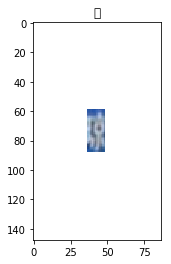

In [14]:
X, y = next(gen(1))#内置函数
#y
# [array([[0, 1, 0, 0, 0]], dtype=uint8), 
#  array([[1, 0, 0, 0, 0]], dtype=uint8),
#  array([[0, 0, 1, 0, 0]], dtype=uint8), 
#  array([[0, 0, 0, 1, 0]], dtype=uint8)]
plt.imshow(X[0])#取第一张图就是 X[0]
# print("x[0]:",X[0])
# print("y:",y,'y.len:',y[0].shape)
plt.title(decode(y))

## 图形展示数据特点

统计每类字符的数量与比例并利用图表展示(直方图、饼状图)

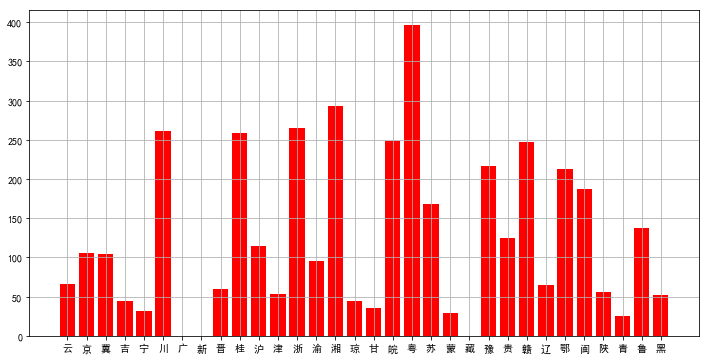

In [15]:
from IPython.display import Image as Image1
Image1('bar.png')

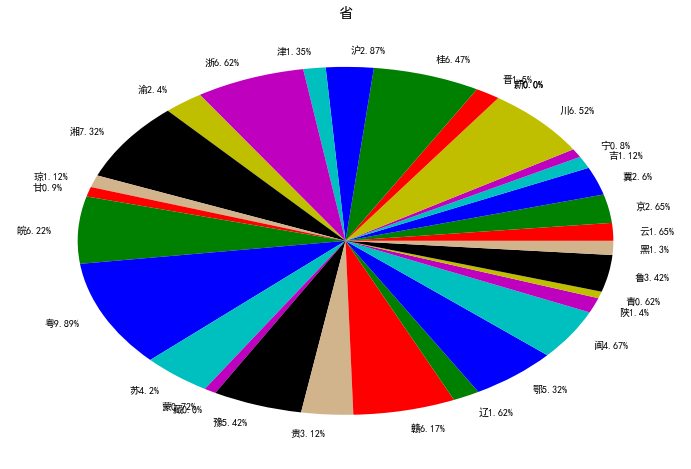

In [17]:
Image1('pie.jpeg')

### 定义网络结构

In [18]:
from keras.models import *
from keras.layers import *
input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):#########卷积层数,3层可达99%，4层达到100%
    x = Convolution2D(16*2**i, 3, 3, activation='relu')(x)#32
    x = Convolution2D(16*2**i, 3, 3, activation='relu')(x)#32
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)##########正则化
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(1)]##4，模型结果预测数量
model = Model(input=input_tensor, output=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `

### 算法过程描述可视化

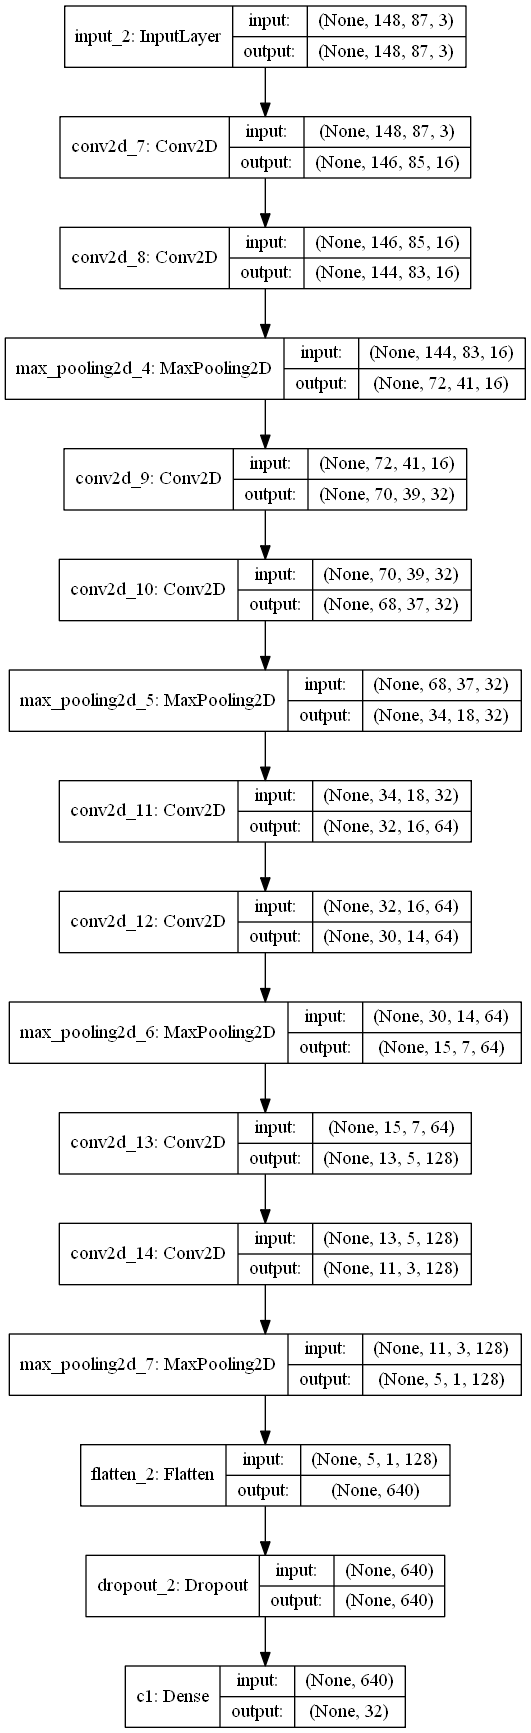

In [19]:
Image1('model.png',width=300, height=500)

## 训练模型     并计算当前模型的识别正确率，ACC

In [29]:
model.fit_generator(gen(captcha_list_img=captcha_list_img), samples_per_epoch=5120, nb_epoch=2,validation_data=gen(captcha_list_img=captcha_list_img), nb_val_samples=1280)#samples_per_epoch=51200,nb_epoch=5

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=5120, epochs=2, validation_steps=1280)`
  """Entry point for launching an IPython kernel.


Epoch 1/2


 204/5120 [>.............................] - ETA: 6014s - loss: 13.2179 - acc: 0.031 - ETA: 3571s - loss: 13.2344 - acc: 0.015 - ETA: 2758s - loss: 13.0337 - acc: 0.020 - ETA: 2354s - loss: 12.5856 - acc: 0.031 - ETA: 2115s - loss: 11.4256 - acc: 0.043 - ETA: 1955s - loss: 10.4887 - acc: 0.036 - ETA: 1847s - loss: 9.4771 - acc: 0.049 - ETA: 1761s - loss: 8.8277 - acc: 0.05 - ETA: 1693s - loss: 8.2418 - acc: 0.05 - ETA: 1639s - loss: 7.7479 - acc: 0.06 - ETA: 1594s - loss: 7.3575 - acc: 0.05 - ETA: 1557s - loss: 7.0319 - acc: 0.05 - ETA: 1530s - loss: 6.7675 - acc: 0.06 - ETA: 1502s - loss: 6.5312 - acc: 0.06 - ETA: 1479s - loss: 6.3360 - acc: 0.06 - ETA: 1459s - loss: 6.1497 - acc: 0.06 - ETA: 1441s - loss: 5.9815 - acc: 0.06 - ETA: 1425s - loss: 5.8289 - acc: 0.06 - ETA: 1410s - loss: 5.6916 - acc: 0.06 - ETA: 1397s - loss: 5.5765 - acc: 0.06 - ETA: 1385s - loss: 5.4703 - acc: 0.06 - ETA: 1374s - loss: 5.3752 - acc: 0.06 - ETA: 1364s - loss: 5.2890 - acc: 0.06 - ETA: 1355s - loss: 5.2

 612/5120 [==>...........................] - ETA: 1088s - loss: 2.8025 - acc: 0.25 - ETA: 1087s - loss: 2.7991 - acc: 0.25 - ETA: 1087s - loss: 2.7967 - acc: 0.25 - ETA: 1087s - loss: 2.7953 - acc: 0.25 - ETA: 1087s - loss: 2.7937 - acc: 0.25 - ETA: 1086s - loss: 2.7909 - acc: 0.25 - ETA: 1086s - loss: 2.7873 - acc: 0.25 - ETA: 1086s - loss: 2.7841 - acc: 0.25 - ETA: 1085s - loss: 2.7815 - acc: 0.26 - ETA: 1085s - loss: 2.7792 - acc: 0.26 - ETA: 1085s - loss: 2.7759 - acc: 0.26 - ETA: 1085s - loss: 2.7716 - acc: 0.26 - ETA: 1084s - loss: 2.7681 - acc: 0.26 - ETA: 1084s - loss: 2.7653 - acc: 0.26 - ETA: 1084s - loss: 2.7623 - acc: 0.26 - ETA: 1084s - loss: 2.7597 - acc: 0.26 - ETA: 1083s - loss: 2.7570 - acc: 0.26 - ETA: 1083s - loss: 2.7533 - acc: 0.26 - ETA: 1083s - loss: 2.7508 - acc: 0.26 - ETA: 1083s - loss: 2.7474 - acc: 0.26 - ETA: 1082s - loss: 2.7440 - acc: 0.26 - ETA: 1082s - loss: 2.7429 - acc: 0.27 - ETA: 1082s - loss: 2.7405 - acc: 0.27 - ETA: 1082s - loss: 2.7380 - acc: 0.

 816/5120 [===>..........................] - ETA: 1040s - loss: 2.2468 - acc: 0.40 - ETA: 1040s - loss: 2.2440 - acc: 0.40 - ETA: 1040s - loss: 2.2412 - acc: 0.40 - ETA: 1039s - loss: 2.2393 - acc: 0.40 - ETA: 1039s - loss: 2.2379 - acc: 0.40 - ETA: 1039s - loss: 2.2358 - acc: 0.40 - ETA: 1038s - loss: 2.2330 - acc: 0.40 - ETA: 1038s - loss: 2.2302 - acc: 0.40 - ETA: 1038s - loss: 2.2272 - acc: 0.40 - ETA: 1038s - loss: 2.2246 - acc: 0.40 - ETA: 1037s - loss: 2.2221 - acc: 0.41 - ETA: 1037s - loss: 2.2207 - acc: 0.41 - ETA: 1037s - loss: 2.2188 - acc: 0.41 - ETA: 1037s - loss: 2.2164 - acc: 0.41 - ETA: 1036s - loss: 2.2146 - acc: 0.41 - ETA: 1036s - loss: 2.2127 - acc: 0.41 - ETA: 1036s - loss: 2.2109 - acc: 0.41 - ETA: 1036s - loss: 2.2086 - acc: 0.41 - ETA: 1035s - loss: 2.2061 - acc: 0.41 - ETA: 1035s - loss: 2.2037 - acc: 0.41 - ETA: 1035s - loss: 2.2014 - acc: 0.41 - ETA: 1035s - loss: 2.1996 - acc: 0.41 - ETA: 1034s - loss: 2.1972 - acc: 0.41 - ETA: 1034s - loss: 2.1946 - acc: 0.

1020/5120 [====>.........................] - ETA: 989s - loss: 1.8300 - acc: 0.518 - ETA: 988s - loss: 1.8284 - acc: 0.519 - ETA: 988s - loss: 1.8265 - acc: 0.519 - ETA: 988s - loss: 1.8247 - acc: 0.520 - ETA: 988s - loss: 1.8230 - acc: 0.520 - ETA: 987s - loss: 1.8214 - acc: 0.520 - ETA: 987s - loss: 1.8194 - acc: 0.521 - ETA: 987s - loss: 1.8176 - acc: 0.522 - ETA: 987s - loss: 1.8157 - acc: 0.522 - ETA: 986s - loss: 1.8141 - acc: 0.522 - ETA: 986s - loss: 1.8123 - acc: 0.523 - ETA: 986s - loss: 1.8107 - acc: 0.523 - ETA: 986s - loss: 1.8088 - acc: 0.524 - ETA: 985s - loss: 1.8069 - acc: 0.524 - ETA: 985s - loss: 1.8053 - acc: 0.525 - ETA: 985s - loss: 1.8036 - acc: 0.525 - ETA: 985s - loss: 1.8021 - acc: 0.526 - ETA: 984s - loss: 1.8005 - acc: 0.526 - ETA: 984s - loss: 1.7996 - acc: 0.526 - ETA: 984s - loss: 1.7983 - acc: 0.527 - ETA: 983s - loss: 1.7967 - acc: 0.527 - ETA: 983s - loss: 1.7950 - acc: 0.528 - ETA: 983s - loss: 1.7934 - acc: 0.528 - ETA: 983s - loss: 1.7916 - acc: 0.5

1224/5120 [======>.......................] - ETA: 939s - loss: 1.5495 - acc: 0.596 - ETA: 938s - loss: 1.5483 - acc: 0.596 - ETA: 938s - loss: 1.5471 - acc: 0.597 - ETA: 938s - loss: 1.5458 - acc: 0.597 - ETA: 938s - loss: 1.5446 - acc: 0.597 - ETA: 937s - loss: 1.5433 - acc: 0.598 - ETA: 937s - loss: 1.5420 - acc: 0.598 - ETA: 937s - loss: 1.5407 - acc: 0.598 - ETA: 937s - loss: 1.5394 - acc: 0.599 - ETA: 936s - loss: 1.5382 - acc: 0.599 - ETA: 936s - loss: 1.5368 - acc: 0.599 - ETA: 936s - loss: 1.5354 - acc: 0.600 - ETA: 936s - loss: 1.5340 - acc: 0.600 - ETA: 935s - loss: 1.5326 - acc: 0.600 - ETA: 935s - loss: 1.5312 - acc: 0.601 - ETA: 935s - loss: 1.5301 - acc: 0.601 - ETA: 935s - loss: 1.5292 - acc: 0.601 - ETA: 934s - loss: 1.5280 - acc: 0.602 - ETA: 934s - loss: 1.5277 - acc: 0.602 - ETA: 934s - loss: 1.5266 - acc: 0.602 - ETA: 934s - loss: 1.5254 - acc: 0.603 - ETA: 933s - loss: 1.5241 - acc: 0.603 - ETA: 933s - loss: 1.5227 - acc: 0.603 - ETA: 933s - loss: 1.5216 - acc: 0.6

1428/5120 [=======>......................] - ETA: 890s - loss: 1.3518 - acc: 0.653 - ETA: 889s - loss: 1.3508 - acc: 0.653 - ETA: 889s - loss: 1.3501 - acc: 0.653 - ETA: 889s - loss: 1.3491 - acc: 0.654 - ETA: 889s - loss: 1.3486 - acc: 0.654 - ETA: 888s - loss: 1.3475 - acc: 0.654 - ETA: 888s - loss: 1.3466 - acc: 0.654 - ETA: 888s - loss: 1.3456 - acc: 0.655 - ETA: 888s - loss: 1.3447 - acc: 0.655 - ETA: 887s - loss: 1.3436 - acc: 0.655 - ETA: 887s - loss: 1.3426 - acc: 0.655 - ETA: 887s - loss: 1.3416 - acc: 0.656 - ETA: 887s - loss: 1.3409 - acc: 0.656 - ETA: 886s - loss: 1.3403 - acc: 0.656 - ETA: 886s - loss: 1.3393 - acc: 0.656 - ETA: 886s - loss: 1.3391 - acc: 0.656 - ETA: 886s - loss: 1.3387 - acc: 0.657 - ETA: 885s - loss: 1.3377 - acc: 0.657 - ETA: 885s - loss: 1.3367 - acc: 0.657 - ETA: 885s - loss: 1.3369 - acc: 0.657 - ETA: 885s - loss: 1.3359 - acc: 0.658 - ETA: 885s - loss: 1.3350 - acc: 0.658 - ETA: 884s - loss: 1.3339 - acc: 0.658 - ETA: 884s - loss: 1.3332 - acc: 0.6

1632/5120 [========>.....................] - ETA: 843s - loss: 1.2027 - acc: 0.696 - ETA: 842s - loss: 1.2022 - acc: 0.696 - ETA: 842s - loss: 1.2015 - acc: 0.696 - ETA: 842s - loss: 1.2008 - acc: 0.696 - ETA: 842s - loss: 1.2001 - acc: 0.696 - ETA: 841s - loss: 1.1993 - acc: 0.697 - ETA: 841s - loss: 1.1985 - acc: 0.697 - ETA: 841s - loss: 1.1983 - acc: 0.697 - ETA: 841s - loss: 1.1976 - acc: 0.697 - ETA: 840s - loss: 1.1968 - acc: 0.697 - ETA: 840s - loss: 1.1961 - acc: 0.697 - ETA: 840s - loss: 1.1953 - acc: 0.698 - ETA: 840s - loss: 1.1945 - acc: 0.698 - ETA: 839s - loss: 1.1938 - acc: 0.698 - ETA: 839s - loss: 1.1930 - acc: 0.698 - ETA: 839s - loss: 1.1922 - acc: 0.699 - ETA: 839s - loss: 1.1914 - acc: 0.699 - ETA: 839s - loss: 1.1906 - acc: 0.699 - ETA: 838s - loss: 1.1898 - acc: 0.699 - ETA: 838s - loss: 1.1891 - acc: 0.699 - ETA: 838s - loss: 1.1883 - acc: 0.700 - ETA: 838s - loss: 1.1876 - acc: 0.700 - ETA: 837s - loss: 1.1868 - acc: 0.700 - ETA: 837s - loss: 1.1860 - acc: 0.7

1836/5120 [=========>....................] - ETA: 794s - loss: 1.0813 - acc: 0.729 - ETA: 794s - loss: 1.0806 - acc: 0.729 - ETA: 794s - loss: 1.0800 - acc: 0.730 - ETA: 794s - loss: 1.0794 - acc: 0.730 - ETA: 793s - loss: 1.0788 - acc: 0.730 - ETA: 793s - loss: 1.0781 - acc: 0.730 - ETA: 793s - loss: 1.0781 - acc: 0.730 - ETA: 793s - loss: 1.0774 - acc: 0.730 - ETA: 792s - loss: 1.0769 - acc: 0.730 - ETA: 792s - loss: 1.0763 - acc: 0.731 - ETA: 792s - loss: 1.0756 - acc: 0.731 - ETA: 792s - loss: 1.0757 - acc: 0.731 - ETA: 791s - loss: 1.0750 - acc: 0.731 - ETA: 791s - loss: 1.0745 - acc: 0.731 - ETA: 791s - loss: 1.0739 - acc: 0.731 - ETA: 791s - loss: 1.0733 - acc: 0.731 - ETA: 790s - loss: 1.0727 - acc: 0.732 - ETA: 790s - loss: 1.0721 - acc: 0.732 - ETA: 790s - loss: 1.0715 - acc: 0.732 - ETA: 790s - loss: 1.0709 - acc: 0.732 - ETA: 789s - loss: 1.0703 - acc: 0.732 - ETA: 789s - loss: 1.0696 - acc: 0.732 - ETA: 789s - loss: 1.0690 - acc: 0.732 - ETA: 789s - loss: 1.0688 - acc: 0.7

2040/5120 [==========>...................] - ETA: 747s - loss: 0.9875 - acc: 0.756 - ETA: 746s - loss: 0.9874 - acc: 0.756 - ETA: 746s - loss: 0.9876 - acc: 0.756 - ETA: 746s - loss: 0.9871 - acc: 0.756 - ETA: 746s - loss: 0.9866 - acc: 0.756 - ETA: 745s - loss: 0.9867 - acc: 0.756 - ETA: 745s - loss: 0.9863 - acc: 0.757 - ETA: 745s - loss: 0.9858 - acc: 0.757 - ETA: 745s - loss: 0.9853 - acc: 0.757 - ETA: 744s - loss: 0.9848 - acc: 0.757 - ETA: 744s - loss: 0.9843 - acc: 0.757 - ETA: 744s - loss: 0.9837 - acc: 0.757 - ETA: 744s - loss: 0.9832 - acc: 0.757 - ETA: 743s - loss: 0.9829 - acc: 0.757 - ETA: 743s - loss: 0.9823 - acc: 0.758 - ETA: 743s - loss: 0.9818 - acc: 0.758 - ETA: 743s - loss: 0.9816 - acc: 0.758 - ETA: 742s - loss: 0.9811 - acc: 0.758 - ETA: 742s - loss: 0.9806 - acc: 0.758 - ETA: 742s - loss: 0.9801 - acc: 0.758 - ETA: 742s - loss: 0.9797 - acc: 0.758 - ETA: 741s - loss: 0.9792 - acc: 0.758 - ETA: 741s - loss: 0.9789 - acc: 0.759 - ETA: 741s - loss: 0.9784 - acc: 0.7

2244/5120 [============>.................] - ETA: 699s - loss: 0.9123 - acc: 0.778 - ETA: 699s - loss: 0.9118 - acc: 0.778 - ETA: 699s - loss: 0.9114 - acc: 0.778 - ETA: 698s - loss: 0.9110 - acc: 0.778 - ETA: 698s - loss: 0.9106 - acc: 0.778 - ETA: 698s - loss: 0.9102 - acc: 0.778 - ETA: 698s - loss: 0.9098 - acc: 0.778 - ETA: 698s - loss: 0.9094 - acc: 0.778 - ETA: 697s - loss: 0.9090 - acc: 0.778 - ETA: 697s - loss: 0.9085 - acc: 0.778 - ETA: 697s - loss: 0.9081 - acc: 0.779 - ETA: 697s - loss: 0.9077 - acc: 0.779 - ETA: 696s - loss: 0.9072 - acc: 0.779 - ETA: 696s - loss: 0.9068 - acc: 0.779 - ETA: 696s - loss: 0.9064 - acc: 0.779 - ETA: 696s - loss: 0.9065 - acc: 0.779 - ETA: 695s - loss: 0.9062 - acc: 0.779 - ETA: 695s - loss: 0.9059 - acc: 0.779 - ETA: 695s - loss: 0.9054 - acc: 0.779 - ETA: 695s - loss: 0.9051 - acc: 0.779 - ETA: 695s - loss: 0.9053 - acc: 0.780 - ETA: 694s - loss: 0.9049 - acc: 0.780 - ETA: 694s - loss: 0.9045 - acc: 0.780 - ETA: 694s - loss: 0.9045 - acc: 0.7

2448/5120 [=============>................] - ETA: 652s - loss: 0.8491 - acc: 0.796 - ETA: 652s - loss: 0.8495 - acc: 0.796 - ETA: 652s - loss: 0.8494 - acc: 0.796 - ETA: 651s - loss: 0.8498 - acc: 0.796 - ETA: 651s - loss: 0.8496 - acc: 0.796 - ETA: 651s - loss: 0.8493 - acc: 0.796 - ETA: 651s - loss: 0.8489 - acc: 0.796 - ETA: 651s - loss: 0.8486 - acc: 0.796 - ETA: 650s - loss: 0.8482 - acc: 0.796 - ETA: 650s - loss: 0.8478 - acc: 0.796 - ETA: 650s - loss: 0.8477 - acc: 0.796 - ETA: 650s - loss: 0.8473 - acc: 0.796 - ETA: 649s - loss: 0.8470 - acc: 0.796 - ETA: 649s - loss: 0.8466 - acc: 0.796 - ETA: 649s - loss: 0.8462 - acc: 0.797 - ETA: 649s - loss: 0.8459 - acc: 0.797 - ETA: 648s - loss: 0.8455 - acc: 0.797 - ETA: 648s - loss: 0.8451 - acc: 0.797 - ETA: 648s - loss: 0.8448 - acc: 0.797 - ETA: 648s - loss: 0.8444 - acc: 0.797 - ETA: 648s - loss: 0.8443 - acc: 0.797 - ETA: 647s - loss: 0.8440 - acc: 0.797 - ETA: 647s - loss: 0.8436 - acc: 0.797 - ETA: 647s - loss: 0.8435 - acc: 0.7

2652/5120 [==============>...............] - ETA: 605s - loss: 0.8004 - acc: 0.810 - ETA: 605s - loss: 0.8001 - acc: 0.811 - ETA: 605s - loss: 0.7998 - acc: 0.811 - ETA: 605s - loss: 0.7997 - acc: 0.811 - ETA: 604s - loss: 0.7994 - acc: 0.811 - ETA: 604s - loss: 0.7992 - acc: 0.811 - ETA: 604s - loss: 0.7989 - acc: 0.811 - ETA: 604s - loss: 0.7985 - acc: 0.811 - ETA: 603s - loss: 0.7982 - acc: 0.811 - ETA: 603s - loss: 0.7981 - acc: 0.811 - ETA: 603s - loss: 0.7978 - acc: 0.811 - ETA: 603s - loss: 0.7975 - acc: 0.811 - ETA: 602s - loss: 0.7972 - acc: 0.811 - ETA: 602s - loss: 0.7970 - acc: 0.811 - ETA: 602s - loss: 0.7966 - acc: 0.811 - ETA: 602s - loss: 0.7963 - acc: 0.811 - ETA: 602s - loss: 0.7960 - acc: 0.812 - ETA: 601s - loss: 0.7958 - acc: 0.812 - ETA: 601s - loss: 0.7955 - acc: 0.812 - ETA: 601s - loss: 0.7952 - acc: 0.812 - ETA: 601s - loss: 0.7949 - acc: 0.812 - ETA: 600s - loss: 0.7946 - acc: 0.812 - ETA: 600s - loss: 0.7943 - acc: 0.812 - ETA: 600s - loss: 0.7940 - acc: 0.8

2856/5120 [===============>..............] - ETA: 558s - loss: 0.7570 - acc: 0.823 - ETA: 558s - loss: 0.7572 - acc: 0.823 - ETA: 558s - loss: 0.7569 - acc: 0.823 - ETA: 558s - loss: 0.7567 - acc: 0.823 - ETA: 558s - loss: 0.7564 - acc: 0.823 - ETA: 557s - loss: 0.7562 - acc: 0.823 - ETA: 557s - loss: 0.7559 - acc: 0.823 - ETA: 557s - loss: 0.7557 - acc: 0.824 - ETA: 557s - loss: 0.7555 - acc: 0.824 - ETA: 556s - loss: 0.7552 - acc: 0.824 - ETA: 556s - loss: 0.7549 - acc: 0.824 - ETA: 556s - loss: 0.7547 - acc: 0.824 - ETA: 556s - loss: 0.7544 - acc: 0.824 - ETA: 555s - loss: 0.7541 - acc: 0.824 - ETA: 555s - loss: 0.7538 - acc: 0.824 - ETA: 555s - loss: 0.7535 - acc: 0.824 - ETA: 555s - loss: 0.7533 - acc: 0.824 - ETA: 555s - loss: 0.7530 - acc: 0.824 - ETA: 554s - loss: 0.7527 - acc: 0.824 - ETA: 554s - loss: 0.7524 - acc: 0.824 - ETA: 554s - loss: 0.7522 - acc: 0.824 - ETA: 554s - loss: 0.7519 - acc: 0.824 - ETA: 553s - loss: 0.7520 - acc: 0.825 - ETA: 553s - loss: 0.7517 - acc: 0.8

3060/5120 [================>.............] - ETA: 512s - loss: 0.7182 - acc: 0.834 - ETA: 512s - loss: 0.7180 - acc: 0.834 - ETA: 511s - loss: 0.7177 - acc: 0.834 - ETA: 511s - loss: 0.7175 - acc: 0.834 - ETA: 511s - loss: 0.7172 - acc: 0.834 - ETA: 511s - loss: 0.7170 - acc: 0.835 - ETA: 510s - loss: 0.7168 - acc: 0.835 - ETA: 510s - loss: 0.7166 - acc: 0.835 - ETA: 510s - loss: 0.7167 - acc: 0.835 - ETA: 510s - loss: 0.7164 - acc: 0.835 - ETA: 510s - loss: 0.7162 - acc: 0.835 - ETA: 509s - loss: 0.7160 - acc: 0.835 - ETA: 509s - loss: 0.7159 - acc: 0.835 - ETA: 509s - loss: 0.7157 - acc: 0.835 - ETA: 509s - loss: 0.7154 - acc: 0.835 - ETA: 508s - loss: 0.7152 - acc: 0.835 - ETA: 508s - loss: 0.7150 - acc: 0.835 - ETA: 508s - loss: 0.7150 - acc: 0.835 - ETA: 508s - loss: 0.7148 - acc: 0.835 - ETA: 507s - loss: 0.7146 - acc: 0.835 - ETA: 507s - loss: 0.7143 - acc: 0.835 - ETA: 507s - loss: 0.7142 - acc: 0.835 - ETA: 507s - loss: 0.7144 - acc: 0.835 - ETA: 507s - loss: 0.7148 - acc: 0.8

3264/5120 [==================>...........] - ETA: 465s - loss: 0.6863 - acc: 0.844 - ETA: 465s - loss: 0.6861 - acc: 0.844 - ETA: 465s - loss: 0.6859 - acc: 0.844 - ETA: 465s - loss: 0.6857 - acc: 0.844 - ETA: 465s - loss: 0.6855 - acc: 0.844 - ETA: 464s - loss: 0.6852 - acc: 0.844 - ETA: 464s - loss: 0.6850 - acc: 0.844 - ETA: 464s - loss: 0.6848 - acc: 0.844 - ETA: 464s - loss: 0.6846 - acc: 0.844 - ETA: 463s - loss: 0.6844 - acc: 0.844 - ETA: 463s - loss: 0.6841 - acc: 0.844 - ETA: 463s - loss: 0.6839 - acc: 0.844 - ETA: 463s - loss: 0.6840 - acc: 0.844 - ETA: 462s - loss: 0.6838 - acc: 0.844 - ETA: 462s - loss: 0.6836 - acc: 0.844 - ETA: 462s - loss: 0.6834 - acc: 0.845 - ETA: 462s - loss: 0.6836 - acc: 0.845 - ETA: 462s - loss: 0.6834 - acc: 0.845 - ETA: 461s - loss: 0.6836 - acc: 0.845 - ETA: 461s - loss: 0.6836 - acc: 0.845 - ETA: 461s - loss: 0.6834 - acc: 0.845 - ETA: 461s - loss: 0.6836 - acc: 0.845 - ETA: 460s - loss: 0.6834 - acc: 0.845 - ETA: 460s - loss: 0.6834 - acc: 0.8

3468/5120 [===================>..........] - ETA: 419s - loss: 0.6569 - acc: 0.852 - ETA: 419s - loss: 0.6567 - acc: 0.852 - ETA: 419s - loss: 0.6567 - acc: 0.852 - ETA: 418s - loss: 0.6566 - acc: 0.852 - ETA: 418s - loss: 0.6565 - acc: 0.852 - ETA: 418s - loss: 0.6563 - acc: 0.853 - ETA: 418s - loss: 0.6561 - acc: 0.853 - ETA: 417s - loss: 0.6560 - acc: 0.853 - ETA: 417s - loss: 0.6558 - acc: 0.853 - ETA: 417s - loss: 0.6556 - acc: 0.853 - ETA: 417s - loss: 0.6555 - acc: 0.853 - ETA: 416s - loss: 0.6553 - acc: 0.853 - ETA: 416s - loss: 0.6551 - acc: 0.853 - ETA: 416s - loss: 0.6549 - acc: 0.853 - ETA: 416s - loss: 0.6549 - acc: 0.853 - ETA: 416s - loss: 0.6547 - acc: 0.853 - ETA: 415s - loss: 0.6548 - acc: 0.853 - ETA: 415s - loss: 0.6547 - acc: 0.853 - ETA: 415s - loss: 0.6545 - acc: 0.853 - ETA: 415s - loss: 0.6544 - acc: 0.853 - ETA: 414s - loss: 0.6543 - acc: 0.853 - ETA: 414s - loss: 0.6541 - acc: 0.853 - ETA: 414s - loss: 0.6539 - acc: 0.853 - ETA: 414s - loss: 0.6537 - acc: 0.8

3672/5120 [====================>.........] - ETA: 373s - loss: 0.6328 - acc: 0.860 - ETA: 373s - loss: 0.6326 - acc: 0.860 - ETA: 373s - loss: 0.6325 - acc: 0.860 - ETA: 372s - loss: 0.6323 - acc: 0.860 - ETA: 372s - loss: 0.6321 - acc: 0.860 - ETA: 372s - loss: 0.6319 - acc: 0.860 - ETA: 372s - loss: 0.6318 - acc: 0.860 - ETA: 371s - loss: 0.6316 - acc: 0.860 - ETA: 371s - loss: 0.6314 - acc: 0.860 - ETA: 371s - loss: 0.6312 - acc: 0.860 - ETA: 371s - loss: 0.6311 - acc: 0.860 - ETA: 371s - loss: 0.6309 - acc: 0.860 - ETA: 370s - loss: 0.6307 - acc: 0.860 - ETA: 370s - loss: 0.6306 - acc: 0.860 - ETA: 370s - loss: 0.6304 - acc: 0.860 - ETA: 370s - loss: 0.6305 - acc: 0.860 - ETA: 369s - loss: 0.6304 - acc: 0.860 - ETA: 369s - loss: 0.6302 - acc: 0.860 - ETA: 369s - loss: 0.6301 - acc: 0.860 - ETA: 369s - loss: 0.6301 - acc: 0.860 - ETA: 369s - loss: 0.6300 - acc: 0.860 - ETA: 368s - loss: 0.6299 - acc: 0.860 - ETA: 368s - loss: 0.6298 - acc: 0.860 - ETA: 368s - loss: 0.6296 - acc: 0.8

3876/5120 [=====================>........] - ETA: 327s - loss: 0.6103 - acc: 0.866 - ETA: 327s - loss: 0.6101 - acc: 0.866 - ETA: 327s - loss: 0.6100 - acc: 0.866 - ETA: 326s - loss: 0.6098 - acc: 0.866 - ETA: 326s - loss: 0.6100 - acc: 0.866 - ETA: 326s - loss: 0.6102 - acc: 0.866 - ETA: 326s - loss: 0.6100 - acc: 0.866 - ETA: 326s - loss: 0.6099 - acc: 0.866 - ETA: 325s - loss: 0.6097 - acc: 0.866 - ETA: 325s - loss: 0.6096 - acc: 0.866 - ETA: 325s - loss: 0.6094 - acc: 0.866 - ETA: 325s - loss: 0.6093 - acc: 0.866 - ETA: 324s - loss: 0.6091 - acc: 0.866 - ETA: 324s - loss: 0.6090 - acc: 0.866 - ETA: 324s - loss: 0.6088 - acc: 0.866 - ETA: 324s - loss: 0.6086 - acc: 0.867 - ETA: 324s - loss: 0.6085 - acc: 0.867 - ETA: 323s - loss: 0.6087 - acc: 0.867 - ETA: 323s - loss: 0.6086 - acc: 0.867 - ETA: 323s - loss: 0.6086 - acc: 0.867 - ETA: 323s - loss: 0.6085 - acc: 0.867 - ETA: 322s - loss: 0.6084 - acc: 0.867 - ETA: 322s - loss: 0.6083 - acc: 0.867 - ETA: 322s - loss: 0.6081 - acc: 0.8

4080/5120 [======================>.......] - ETA: 281s - loss: 0.5886 - acc: 0.872 - ETA: 281s - loss: 0.5885 - acc: 0.872 - ETA: 280s - loss: 0.5883 - acc: 0.872 - ETA: 280s - loss: 0.5884 - acc: 0.872 - ETA: 280s - loss: 0.5882 - acc: 0.872 - ETA: 280s - loss: 0.5881 - acc: 0.872 - ETA: 279s - loss: 0.5880 - acc: 0.872 - ETA: 279s - loss: 0.5879 - acc: 0.872 - ETA: 279s - loss: 0.5878 - acc: 0.872 - ETA: 279s - loss: 0.5877 - acc: 0.872 - ETA: 279s - loss: 0.5875 - acc: 0.872 - ETA: 278s - loss: 0.5874 - acc: 0.872 - ETA: 278s - loss: 0.5874 - acc: 0.872 - ETA: 278s - loss: 0.5872 - acc: 0.872 - ETA: 278s - loss: 0.5871 - acc: 0.873 - ETA: 277s - loss: 0.5869 - acc: 0.873 - ETA: 277s - loss: 0.5868 - acc: 0.873 - ETA: 277s - loss: 0.5866 - acc: 0.873 - ETA: 277s - loss: 0.5865 - acc: 0.873 - ETA: 276s - loss: 0.5865 - acc: 0.873 - ETA: 276s - loss: 0.5865 - acc: 0.873 - ETA: 276s - loss: 0.5864 - acc: 0.873 - ETA: 276s - loss: 0.5862 - acc: 0.873 - ETA: 276s - loss: 0.5861 - acc: 0.8

4284/5120 [========================>.....] - ETA: 235s - loss: 0.5704 - acc: 0.877 - ETA: 234s - loss: 0.5702 - acc: 0.877 - ETA: 234s - loss: 0.5702 - acc: 0.878 - ETA: 234s - loss: 0.5703 - acc: 0.878 - ETA: 234s - loss: 0.5702 - acc: 0.878 - ETA: 234s - loss: 0.5701 - acc: 0.878 - ETA: 233s - loss: 0.5700 - acc: 0.878 - ETA: 233s - loss: 0.5699 - acc: 0.878 - ETA: 233s - loss: 0.5698 - acc: 0.878 - ETA: 233s - loss: 0.5697 - acc: 0.878 - ETA: 232s - loss: 0.5696 - acc: 0.878 - ETA: 232s - loss: 0.5696 - acc: 0.878 - ETA: 232s - loss: 0.5696 - acc: 0.878 - ETA: 232s - loss: 0.5695 - acc: 0.878 - ETA: 232s - loss: 0.5694 - acc: 0.878 - ETA: 231s - loss: 0.5692 - acc: 0.878 - ETA: 231s - loss: 0.5693 - acc: 0.878 - ETA: 231s - loss: 0.5693 - acc: 0.878 - ETA: 231s - loss: 0.5691 - acc: 0.878 - ETA: 230s - loss: 0.5690 - acc: 0.878 - ETA: 230s - loss: 0.5689 - acc: 0.878 - ETA: 230s - loss: 0.5688 - acc: 0.878 - ETA: 230s - loss: 0.5686 - acc: 0.878 - ETA: 229s - loss: 0.5685 - acc: 0.8

4488/5120 [=========================>....] - ETA: 189s - loss: 0.5531 - acc: 0.882 - ETA: 188s - loss: 0.5529 - acc: 0.882 - ETA: 188s - loss: 0.5528 - acc: 0.882 - ETA: 188s - loss: 0.5527 - acc: 0.882 - ETA: 188s - loss: 0.5526 - acc: 0.882 - ETA: 187s - loss: 0.5524 - acc: 0.882 - ETA: 187s - loss: 0.5523 - acc: 0.882 - ETA: 187s - loss: 0.5522 - acc: 0.882 - ETA: 187s - loss: 0.5523 - acc: 0.882 - ETA: 186s - loss: 0.5522 - acc: 0.882 - ETA: 186s - loss: 0.5521 - acc: 0.883 - ETA: 186s - loss: 0.5519 - acc: 0.883 - ETA: 186s - loss: 0.5518 - acc: 0.883 - ETA: 186s - loss: 0.5517 - acc: 0.883 - ETA: 185s - loss: 0.5516 - acc: 0.883 - ETA: 185s - loss: 0.5515 - acc: 0.883 - ETA: 185s - loss: 0.5514 - acc: 0.883 - ETA: 185s - loss: 0.5514 - acc: 0.883 - ETA: 184s - loss: 0.5513 - acc: 0.883 - ETA: 184s - loss: 0.5512 - acc: 0.883 - ETA: 184s - loss: 0.5511 - acc: 0.883 - ETA: 184s - loss: 0.5512 - acc: 0.883 - ETA: 184s - loss: 0.5511 - acc: 0.883 - ETA: 183s - loss: 0.5510 - acc: 0.8

4693/5120 [==========================>...] - ETA: 142s - loss: 0.5361 - acc: 0.887 - ETA: 142s - loss: 0.5360 - acc: 0.887 - ETA: 142s - loss: 0.5359 - acc: 0.887 - ETA: 142s - loss: 0.5361 - acc: 0.887 - ETA: 141s - loss: 0.5360 - acc: 0.887 - ETA: 141s - loss: 0.5360 - acc: 0.887 - ETA: 141s - loss: 0.5359 - acc: 0.887 - ETA: 141s - loss: 0.5358 - acc: 0.887 - ETA: 141s - loss: 0.5358 - acc: 0.887 - ETA: 140s - loss: 0.5357 - acc: 0.887 - ETA: 140s - loss: 0.5356 - acc: 0.887 - ETA: 140s - loss: 0.5354 - acc: 0.887 - ETA: 140s - loss: 0.5353 - acc: 0.887 - ETA: 139s - loss: 0.5352 - acc: 0.887 - ETA: 139s - loss: 0.5351 - acc: 0.887 - ETA: 139s - loss: 0.5352 - acc: 0.887 - ETA: 139s - loss: 0.5351 - acc: 0.887 - ETA: 139s - loss: 0.5350 - acc: 0.887 - ETA: 138s - loss: 0.5349 - acc: 0.887 - ETA: 138s - loss: 0.5348 - acc: 0.887 - ETA: 138s - loss: 0.5347 - acc: 0.887 - ETA: 138s - loss: 0.5348 - acc: 0.887 - ETA: 137s - loss: 0.5347 - acc: 0.887 - ETA: 137s - loss: 0.5345 - acc: 0.8

4908/5120 [===========================>..] - ETA: 96s - loss: 0.5217 - acc: 0.89 - ETA: 96s - loss: 0.5216 - acc: 0.89 - ETA: 96s - loss: 0.5215 - acc: 0.89 - ETA: 95s - loss: 0.5214 - acc: 0.89 - ETA: 95s - loss: 0.5213 - acc: 0.89 - ETA: 95s - loss: 0.5212 - acc: 0.89 - ETA: 95s - loss: 0.5211 - acc: 0.89 - ETA: 94s - loss: 0.5210 - acc: 0.89 - ETA: 94s - loss: 0.5209 - acc: 0.89 - ETA: 94s - loss: 0.5208 - acc: 0.89 - ETA: 94s - loss: 0.5207 - acc: 0.89 - ETA: 94s - loss: 0.5206 - acc: 0.89 - ETA: 93s - loss: 0.5205 - acc: 0.89 - ETA: 93s - loss: 0.5204 - acc: 0.89 - ETA: 93s - loss: 0.5203 - acc: 0.89 - ETA: 93s - loss: 0.5202 - acc: 0.89 - ETA: 92s - loss: 0.5200 - acc: 0.89 - ETA: 92s - loss: 0.5199 - acc: 0.89 - ETA: 92s - loss: 0.5198 - acc: 0.89 - ETA: 92s - loss: 0.5198 - acc: 0.89 - ETA: 91s - loss: 0.5197 - acc: 0.89 - ETA: 91s - loss: 0.5196 - acc: 0.89 - ETA: 91s - loss: 0.5195 - acc: 0.89 - ETA: 91s - loss: 0.5194 - acc: 0.89 - ETA: 91s - loss: 0.5193 - acc: 0.89 - ETA: 

5120/5120 [==============================] - ETA: 47s - loss: 0.5058 - acc: 0.89 - ETA: 47s - loss: 0.5057 - acc: 0.89 - ETA: 47s - loss: 0.5056 - acc: 0.89 - ETA: 47s - loss: 0.5055 - acc: 0.89 - ETA: 46s - loss: 0.5054 - acc: 0.89 - ETA: 46s - loss: 0.5054 - acc: 0.89 - ETA: 46s - loss: 0.5053 - acc: 0.89 - ETA: 46s - loss: 0.5054 - acc: 0.89 - ETA: 46s - loss: 0.5053 - acc: 0.89 - ETA: 45s - loss: 0.5052 - acc: 0.89 - ETA: 45s - loss: 0.5051 - acc: 0.89 - ETA: 45s - loss: 0.5050 - acc: 0.89 - ETA: 45s - loss: 0.5049 - acc: 0.89 - ETA: 44s - loss: 0.5048 - acc: 0.89 - ETA: 44s - loss: 0.5049 - acc: 0.89 - ETA: 44s - loss: 0.5048 - acc: 0.89 - ETA: 44s - loss: 0.5047 - acc: 0.89 - ETA: 44s - loss: 0.5046 - acc: 0.89 - ETA: 43s - loss: 0.5045 - acc: 0.89 - ETA: 43s - loss: 0.5044 - acc: 0.89 - ETA: 43s - loss: 0.5043 - acc: 0.89 - ETA: 43s - loss: 0.5044 - acc: 0.89 - ETA: 42s - loss: 0.5043 - acc: 0.89 - ETA: 42s - loss: 0.5043 - acc: 0.89 - ETA: 42s - loss: 0.5043 - acc: 0.89 - ETA: 

 204/5120 [>.............................] - ETA: 1100s - loss: 0.0436 - acc: 1.00 - ETA: 1122s - loss: 0.3840 - acc: 0.96 - ETA: 1133s - loss: 0.2840 - acc: 0.97 - ETA: 1136s - loss: 0.2176 - acc: 0.98 - ETA: 1134s - loss: 0.2449 - acc: 0.98 - ETA: 1144s - loss: 0.3439 - acc: 0.96 - ETA: 1145s - loss: 0.3133 - acc: 0.97 - ETA: 1143s - loss: 0.2784 - acc: 0.97 - ETA: 1141s - loss: 0.2509 - acc: 0.97 - ETA: 1139s - loss: 0.2279 - acc: 0.98 - ETA: 1137s - loss: 0.2095 - acc: 0.98 - ETA: 1136s - loss: 0.1940 - acc: 0.98 - ETA: 1135s - loss: 0.2153 - acc: 0.98 - ETA: 1135s - loss: 0.2010 - acc: 0.98 - ETA: 1135s - loss: 0.1908 - acc: 0.98 - ETA: 1134s - loss: 0.1796 - acc: 0.98 - ETA: 1133s - loss: 0.2243 - acc: 0.98 - ETA: 1132s - loss: 0.2133 - acc: 0.98 - ETA: 1132s - loss: 0.2037 - acc: 0.98 - ETA: 1131s - loss: 0.1946 - acc: 0.98 - ETA: 1131s - loss: 0.1859 - acc: 0.98 - ETA: 1131s - loss: 0.1945 - acc: 0.98 - ETA: 1130s - loss: 0.1880 - acc: 0.98 - ETA: 1130s - loss: 0.2059 - acc: 0.

 612/5120 [==>...........................] - ETA: 1068s - loss: 0.2536 - acc: 0.97 - ETA: 1067s - loss: 0.2530 - acc: 0.97 - ETA: 1067s - loss: 0.2533 - acc: 0.97 - ETA: 1067s - loss: 0.2534 - acc: 0.97 - ETA: 1067s - loss: 0.2529 - acc: 0.97 - ETA: 1067s - loss: 0.2523 - acc: 0.97 - ETA: 1066s - loss: 0.2518 - acc: 0.97 - ETA: 1066s - loss: 0.2529 - acc: 0.97 - ETA: 1066s - loss: 0.2534 - acc: 0.97 - ETA: 1065s - loss: 0.2532 - acc: 0.97 - ETA: 1065s - loss: 0.2527 - acc: 0.97 - ETA: 1065s - loss: 0.2531 - acc: 0.97 - ETA: 1065s - loss: 0.2539 - acc: 0.97 - ETA: 1064s - loss: 0.2542 - acc: 0.97 - ETA: 1064s - loss: 0.2548 - acc: 0.97 - ETA: 1064s - loss: 0.2551 - acc: 0.97 - ETA: 1064s - loss: 0.2565 - acc: 0.97 - ETA: 1063s - loss: 0.2561 - acc: 0.97 - ETA: 1063s - loss: 0.2567 - acc: 0.97 - ETA: 1063s - loss: 0.2567 - acc: 0.97 - ETA: 1063s - loss: 0.2561 - acc: 0.97 - ETA: 1063s - loss: 0.2557 - acc: 0.97 - ETA: 1062s - loss: 0.2552 - acc: 0.97 - ETA: 1062s - loss: 0.2547 - acc: 0.

 816/5120 [===>..........................] - ETA: 1022s - loss: 0.2607 - acc: 0.97 - ETA: 1022s - loss: 0.2605 - acc: 0.97 - ETA: 1022s - loss: 0.2602 - acc: 0.97 - ETA: 1022s - loss: 0.2607 - acc: 0.97 - ETA: 1021s - loss: 0.2603 - acc: 0.97 - ETA: 1021s - loss: 0.2600 - acc: 0.97 - ETA: 1021s - loss: 0.2608 - acc: 0.97 - ETA: 1021s - loss: 0.2605 - acc: 0.97 - ETA: 1021s - loss: 0.2606 - acc: 0.97 - ETA: 1020s - loss: 0.2602 - acc: 0.97 - ETA: 1020s - loss: 0.2598 - acc: 0.97 - ETA: 1020s - loss: 0.2594 - acc: 0.97 - ETA: 1020s - loss: 0.2591 - acc: 0.97 - ETA: 1019s - loss: 0.2591 - acc: 0.97 - ETA: 1019s - loss: 0.2592 - acc: 0.97 - ETA: 1019s - loss: 0.2589 - acc: 0.97 - ETA: 1019s - loss: 0.2585 - acc: 0.97 - ETA: 1018s - loss: 0.2582 - acc: 0.97 - ETA: 1018s - loss: 0.2580 - acc: 0.97 - ETA: 1018s - loss: 0.2591 - acc: 0.97 - ETA: 1018s - loss: 0.2588 - acc: 0.97 - ETA: 1017s - loss: 0.2596 - acc: 0.97 - ETA: 1017s - loss: 0.2593 - acc: 0.97 - ETA: 1017s - loss: 0.2601 - acc: 0.

1020/5120 [====>.........................] - ETA: 976s - loss: 0.2482 - acc: 0.976 - ETA: 975s - loss: 0.2480 - acc: 0.976 - ETA: 975s - loss: 0.2477 - acc: 0.976 - ETA: 975s - loss: 0.2474 - acc: 0.976 - ETA: 975s - loss: 0.2471 - acc: 0.976 - ETA: 975s - loss: 0.2469 - acc: 0.976 - ETA: 974s - loss: 0.2466 - acc: 0.976 - ETA: 974s - loss: 0.2463 - acc: 0.976 - ETA: 974s - loss: 0.2460 - acc: 0.977 - ETA: 974s - loss: 0.2457 - acc: 0.977 - ETA: 973s - loss: 0.2454 - acc: 0.977 - ETA: 973s - loss: 0.2451 - acc: 0.977 - ETA: 973s - loss: 0.2448 - acc: 0.977 - ETA: 973s - loss: 0.2445 - acc: 0.977 - ETA: 973s - loss: 0.2443 - acc: 0.977 - ETA: 972s - loss: 0.2440 - acc: 0.977 - ETA: 972s - loss: 0.2437 - acc: 0.977 - ETA: 972s - loss: 0.2434 - acc: 0.977 - ETA: 972s - loss: 0.2435 - acc: 0.977 - ETA: 971s - loss: 0.2433 - acc: 0.977 - ETA: 971s - loss: 0.2430 - acc: 0.977 - ETA: 971s - loss: 0.2427 - acc: 0.977 - ETA: 971s - loss: 0.2424 - acc: 0.977 - ETA: 971s - loss: 0.2429 - acc: 0.9

1224/5120 [======>.......................] - ETA: 929s - loss: 0.2314 - acc: 0.978 - ETA: 929s - loss: 0.2316 - acc: 0.978 - ETA: 929s - loss: 0.2317 - acc: 0.978 - ETA: 928s - loss: 0.2315 - acc: 0.978 - ETA: 928s - loss: 0.2313 - acc: 0.978 - ETA: 928s - loss: 0.2311 - acc: 0.978 - ETA: 928s - loss: 0.2320 - acc: 0.978 - ETA: 927s - loss: 0.2319 - acc: 0.978 - ETA: 927s - loss: 0.2317 - acc: 0.978 - ETA: 927s - loss: 0.2315 - acc: 0.978 - ETA: 927s - loss: 0.2313 - acc: 0.978 - ETA: 927s - loss: 0.2313 - acc: 0.978 - ETA: 926s - loss: 0.2318 - acc: 0.978 - ETA: 926s - loss: 0.2317 - acc: 0.978 - ETA: 926s - loss: 0.2315 - acc: 0.978 - ETA: 926s - loss: 0.2317 - acc: 0.978 - ETA: 925s - loss: 0.2315 - acc: 0.978 - ETA: 925s - loss: 0.2313 - acc: 0.978 - ETA: 925s - loss: 0.2311 - acc: 0.978 - ETA: 925s - loss: 0.2314 - acc: 0.978 - ETA: 925s - loss: 0.2313 - acc: 0.978 - ETA: 924s - loss: 0.2311 - acc: 0.978 - ETA: 924s - loss: 0.2309 - acc: 0.978 - ETA: 924s - loss: 0.2306 - acc: 0.9

1428/5120 [=======>......................] - ETA: 885s - loss: 0.2304 - acc: 0.978 - ETA: 885s - loss: 0.2306 - acc: 0.978 - ETA: 884s - loss: 0.2305 - acc: 0.978 - ETA: 884s - loss: 0.2310 - acc: 0.978 - ETA: 884s - loss: 0.2309 - acc: 0.978 - ETA: 884s - loss: 0.2308 - acc: 0.978 - ETA: 884s - loss: 0.2306 - acc: 0.978 - ETA: 883s - loss: 0.2305 - acc: 0.978 - ETA: 883s - loss: 0.2308 - acc: 0.978 - ETA: 883s - loss: 0.2307 - acc: 0.978 - ETA: 883s - loss: 0.2305 - acc: 0.978 - ETA: 883s - loss: 0.2304 - acc: 0.978 - ETA: 882s - loss: 0.2307 - acc: 0.978 - ETA: 882s - loss: 0.2305 - acc: 0.978 - ETA: 882s - loss: 0.2309 - acc: 0.978 - ETA: 882s - loss: 0.2312 - acc: 0.978 - ETA: 881s - loss: 0.2310 - acc: 0.978 - ETA: 881s - loss: 0.2309 - acc: 0.978 - ETA: 881s - loss: 0.2307 - acc: 0.978 - ETA: 881s - loss: 0.2310 - acc: 0.978 - ETA: 880s - loss: 0.2308 - acc: 0.978 - ETA: 880s - loss: 0.2314 - acc: 0.978 - ETA: 880s - loss: 0.2313 - acc: 0.978 - ETA: 880s - loss: 0.2312 - acc: 0.9

1632/5120 [========>.....................] - ETA: 837s - loss: 0.2252 - acc: 0.979 - ETA: 837s - loss: 0.2250 - acc: 0.979 - ETA: 837s - loss: 0.2249 - acc: 0.979 - ETA: 837s - loss: 0.2247 - acc: 0.979 - ETA: 836s - loss: 0.2246 - acc: 0.979 - ETA: 836s - loss: 0.2244 - acc: 0.979 - ETA: 836s - loss: 0.2243 - acc: 0.979 - ETA: 836s - loss: 0.2247 - acc: 0.979 - ETA: 836s - loss: 0.2246 - acc: 0.979 - ETA: 835s - loss: 0.2246 - acc: 0.979 - ETA: 835s - loss: 0.2248 - acc: 0.979 - ETA: 835s - loss: 0.2248 - acc: 0.979 - ETA: 835s - loss: 0.2246 - acc: 0.979 - ETA: 834s - loss: 0.2245 - acc: 0.979 - ETA: 834s - loss: 0.2244 - acc: 0.979 - ETA: 834s - loss: 0.2245 - acc: 0.979 - ETA: 834s - loss: 0.2243 - acc: 0.979 - ETA: 833s - loss: 0.2242 - acc: 0.979 - ETA: 833s - loss: 0.2240 - acc: 0.979 - ETA: 833s - loss: 0.2239 - acc: 0.979 - ETA: 833s - loss: 0.2237 - acc: 0.979 - ETA: 833s - loss: 0.2236 - acc: 0.979 - ETA: 832s - loss: 0.2234 - acc: 0.979 - ETA: 832s - loss: 0.2233 - acc: 0.9

1836/5120 [=========>....................] - ETA: 790s - loss: 0.2184 - acc: 0.979 - ETA: 790s - loss: 0.2184 - acc: 0.979 - ETA: 790s - loss: 0.2188 - acc: 0.979 - ETA: 789s - loss: 0.2189 - acc: 0.979 - ETA: 789s - loss: 0.2190 - acc: 0.979 - ETA: 789s - loss: 0.2190 - acc: 0.979 - ETA: 789s - loss: 0.2189 - acc: 0.979 - ETA: 788s - loss: 0.2188 - acc: 0.979 - ETA: 788s - loss: 0.2186 - acc: 0.979 - ETA: 788s - loss: 0.2185 - acc: 0.979 - ETA: 788s - loss: 0.2184 - acc: 0.979 - ETA: 787s - loss: 0.2186 - acc: 0.979 - ETA: 787s - loss: 0.2186 - acc: 0.979 - ETA: 787s - loss: 0.2185 - acc: 0.979 - ETA: 787s - loss: 0.2184 - acc: 0.979 - ETA: 787s - loss: 0.2182 - acc: 0.979 - ETA: 786s - loss: 0.2181 - acc: 0.979 - ETA: 786s - loss: 0.2181 - acc: 0.979 - ETA: 786s - loss: 0.2186 - acc: 0.979 - ETA: 786s - loss: 0.2185 - acc: 0.979 - ETA: 785s - loss: 0.2183 - acc: 0.979 - ETA: 785s - loss: 0.2182 - acc: 0.979 - ETA: 785s - loss: 0.2181 - acc: 0.979 - ETA: 785s - loss: 0.2180 - acc: 0.9

2040/5120 [==========>...................] - ETA: 744s - loss: 0.2136 - acc: 0.980 - ETA: 744s - loss: 0.2135 - acc: 0.980 - ETA: 743s - loss: 0.2133 - acc: 0.980 - ETA: 743s - loss: 0.2137 - acc: 0.980 - ETA: 743s - loss: 0.2138 - acc: 0.980 - ETA: 743s - loss: 0.2137 - acc: 0.980 - ETA: 742s - loss: 0.2139 - acc: 0.980 - ETA: 742s - loss: 0.2141 - acc: 0.980 - ETA: 742s - loss: 0.2140 - acc: 0.980 - ETA: 742s - loss: 0.2142 - acc: 0.980 - ETA: 742s - loss: 0.2141 - acc: 0.980 - ETA: 741s - loss: 0.2145 - acc: 0.980 - ETA: 741s - loss: 0.2145 - acc: 0.980 - ETA: 741s - loss: 0.2144 - acc: 0.980 - ETA: 741s - loss: 0.2143 - acc: 0.980 - ETA: 740s - loss: 0.2146 - acc: 0.980 - ETA: 740s - loss: 0.2145 - acc: 0.980 - ETA: 740s - loss: 0.2144 - acc: 0.980 - ETA: 740s - loss: 0.2143 - acc: 0.980 - ETA: 739s - loss: 0.2142 - acc: 0.980 - ETA: 739s - loss: 0.2141 - acc: 0.980 - ETA: 739s - loss: 0.2144 - acc: 0.980 - ETA: 739s - loss: 0.2143 - acc: 0.980 - ETA: 739s - loss: 0.2142 - acc: 0.9

2244/5120 [============>.................] - ETA: 697s - loss: 0.2085 - acc: 0.980 - ETA: 697s - loss: 0.2084 - acc: 0.980 - ETA: 697s - loss: 0.2086 - acc: 0.980 - ETA: 697s - loss: 0.2085 - acc: 0.980 - ETA: 696s - loss: 0.2085 - acc: 0.980 - ETA: 696s - loss: 0.2084 - acc: 0.980 - ETA: 696s - loss: 0.2083 - acc: 0.980 - ETA: 696s - loss: 0.2082 - acc: 0.980 - ETA: 695s - loss: 0.2081 - acc: 0.980 - ETA: 695s - loss: 0.2085 - acc: 0.980 - ETA: 695s - loss: 0.2084 - acc: 0.980 - ETA: 695s - loss: 0.2083 - acc: 0.980 - ETA: 694s - loss: 0.2082 - acc: 0.980 - ETA: 694s - loss: 0.2082 - acc: 0.980 - ETA: 694s - loss: 0.2081 - acc: 0.980 - ETA: 694s - loss: 0.2080 - acc: 0.980 - ETA: 693s - loss: 0.2079 - acc: 0.980 - ETA: 693s - loss: 0.2079 - acc: 0.980 - ETA: 693s - loss: 0.2078 - acc: 0.980 - ETA: 693s - loss: 0.2081 - acc: 0.980 - ETA: 693s - loss: 0.2080 - acc: 0.980 - ETA: 692s - loss: 0.2080 - acc: 0.980 - ETA: 692s - loss: 0.2079 - acc: 0.980 - ETA: 692s - loss: 0.2078 - acc: 0.9

2448/5120 [=============>................] - ETA: 651s - loss: 0.2024 - acc: 0.981 - ETA: 651s - loss: 0.2023 - acc: 0.981 - ETA: 651s - loss: 0.2022 - acc: 0.981 - ETA: 650s - loss: 0.2021 - acc: 0.981 - ETA: 650s - loss: 0.2020 - acc: 0.981 - ETA: 650s - loss: 0.2022 - acc: 0.981 - ETA: 650s - loss: 0.2021 - acc: 0.981 - ETA: 650s - loss: 0.2020 - acc: 0.981 - ETA: 649s - loss: 0.2025 - acc: 0.981 - ETA: 649s - loss: 0.2024 - acc: 0.981 - ETA: 649s - loss: 0.2024 - acc: 0.981 - ETA: 649s - loss: 0.2023 - acc: 0.981 - ETA: 648s - loss: 0.2022 - acc: 0.981 - ETA: 648s - loss: 0.2025 - acc: 0.981 - ETA: 648s - loss: 0.2024 - acc: 0.981 - ETA: 648s - loss: 0.2023 - acc: 0.981 - ETA: 648s - loss: 0.2022 - acc: 0.981 - ETA: 647s - loss: 0.2023 - acc: 0.981 - ETA: 647s - loss: 0.2022 - acc: 0.981 - ETA: 647s - loss: 0.2021 - acc: 0.981 - ETA: 647s - loss: 0.2020 - acc: 0.981 - ETA: 646s - loss: 0.2019 - acc: 0.981 - ETA: 646s - loss: 0.2022 - acc: 0.981 - ETA: 646s - loss: 0.2023 - acc: 0.9

2652/5120 [==============>...............] - ETA: 605s - loss: 0.1991 - acc: 0.981 - ETA: 605s - loss: 0.1990 - acc: 0.981 - ETA: 605s - loss: 0.1989 - acc: 0.981 - ETA: 605s - loss: 0.1988 - acc: 0.981 - ETA: 604s - loss: 0.1988 - acc: 0.981 - ETA: 604s - loss: 0.1987 - acc: 0.981 - ETA: 604s - loss: 0.1986 - acc: 0.981 - ETA: 604s - loss: 0.1985 - acc: 0.981 - ETA: 603s - loss: 0.1984 - acc: 0.981 - ETA: 603s - loss: 0.1986 - acc: 0.981 - ETA: 603s - loss: 0.1987 - acc: 0.981 - ETA: 603s - loss: 0.1987 - acc: 0.981 - ETA: 603s - loss: 0.1986 - acc: 0.981 - ETA: 602s - loss: 0.1986 - acc: 0.981 - ETA: 602s - loss: 0.1987 - acc: 0.981 - ETA: 602s - loss: 0.1986 - acc: 0.981 - ETA: 602s - loss: 0.1987 - acc: 0.981 - ETA: 601s - loss: 0.1987 - acc: 0.981 - ETA: 601s - loss: 0.1986 - acc: 0.981 - ETA: 601s - loss: 0.1988 - acc: 0.981 - ETA: 601s - loss: 0.1988 - acc: 0.981 - ETA: 600s - loss: 0.1988 - acc: 0.981 - ETA: 600s - loss: 0.1988 - acc: 0.981 - ETA: 600s - loss: 0.1987 - acc: 0.9

2856/5120 [===============>..............] - ETA: 560s - loss: 0.1983 - acc: 0.981 - ETA: 559s - loss: 0.1985 - acc: 0.981 - ETA: 559s - loss: 0.1984 - acc: 0.981 - ETA: 559s - loss: 0.1984 - acc: 0.981 - ETA: 559s - loss: 0.1983 - acc: 0.981 - ETA: 559s - loss: 0.1983 - acc: 0.982 - ETA: 558s - loss: 0.1982 - acc: 0.982 - ETA: 558s - loss: 0.1981 - acc: 0.982 - ETA: 558s - loss: 0.1981 - acc: 0.982 - ETA: 558s - loss: 0.1980 - acc: 0.982 - ETA: 557s - loss: 0.1981 - acc: 0.982 - ETA: 557s - loss: 0.1982 - acc: 0.981 - ETA: 557s - loss: 0.1982 - acc: 0.982 - ETA: 557s - loss: 0.1981 - acc: 0.982 - ETA: 557s - loss: 0.1982 - acc: 0.982 - ETA: 556s - loss: 0.1984 - acc: 0.981 - ETA: 556s - loss: 0.1984 - acc: 0.981 - ETA: 556s - loss: 0.1983 - acc: 0.981 - ETA: 556s - loss: 0.1983 - acc: 0.981 - ETA: 555s - loss: 0.1982 - acc: 0.982 - ETA: 555s - loss: 0.1981 - acc: 0.982 - ETA: 555s - loss: 0.1980 - acc: 0.982 - ETA: 555s - loss: 0.1980 - acc: 0.982 - ETA: 555s - loss: 0.1979 - acc: 0.9

3060/5120 [================>.............] - ETA: 514s - loss: 0.1968 - acc: 0.982 - ETA: 514s - loss: 0.1967 - acc: 0.982 - ETA: 513s - loss: 0.1967 - acc: 0.982 - ETA: 513s - loss: 0.1966 - acc: 0.982 - ETA: 513s - loss: 0.1966 - acc: 0.982 - ETA: 513s - loss: 0.1966 - acc: 0.982 - ETA: 513s - loss: 0.1966 - acc: 0.982 - ETA: 512s - loss: 0.1965 - acc: 0.982 - ETA: 512s - loss: 0.1964 - acc: 0.982 - ETA: 512s - loss: 0.1964 - acc: 0.982 - ETA: 512s - loss: 0.1967 - acc: 0.982 - ETA: 511s - loss: 0.1969 - acc: 0.982 - ETA: 511s - loss: 0.1969 - acc: 0.982 - ETA: 511s - loss: 0.1970 - acc: 0.982 - ETA: 511s - loss: 0.1970 - acc: 0.982 - ETA: 511s - loss: 0.1970 - acc: 0.982 - ETA: 510s - loss: 0.1969 - acc: 0.982 - ETA: 510s - loss: 0.1969 - acc: 0.982 - ETA: 510s - loss: 0.1968 - acc: 0.982 - ETA: 510s - loss: 0.1971 - acc: 0.982 - ETA: 509s - loss: 0.1970 - acc: 0.982 - ETA: 509s - loss: 0.1970 - acc: 0.982 - ETA: 509s - loss: 0.1969 - acc: 0.982 - ETA: 509s - loss: 0.1970 - acc: 0.9

3264/5120 [==================>...........] - ETA: 468s - loss: 0.1976 - acc: 0.982 - ETA: 468s - loss: 0.1976 - acc: 0.982 - ETA: 467s - loss: 0.1976 - acc: 0.982 - ETA: 467s - loss: 0.1975 - acc: 0.982 - ETA: 467s - loss: 0.1975 - acc: 0.982 - ETA: 467s - loss: 0.1974 - acc: 0.982 - ETA: 466s - loss: 0.1973 - acc: 0.982 - ETA: 466s - loss: 0.1974 - acc: 0.982 - ETA: 466s - loss: 0.1973 - acc: 0.982 - ETA: 466s - loss: 0.1976 - acc: 0.982 - ETA: 466s - loss: 0.1975 - acc: 0.982 - ETA: 465s - loss: 0.1975 - acc: 0.982 - ETA: 465s - loss: 0.1975 - acc: 0.982 - ETA: 465s - loss: 0.1974 - acc: 0.982 - ETA: 465s - loss: 0.1977 - acc: 0.982 - ETA: 464s - loss: 0.1977 - acc: 0.982 - ETA: 464s - loss: 0.1977 - acc: 0.982 - ETA: 464s - loss: 0.1977 - acc: 0.982 - ETA: 464s - loss: 0.1976 - acc: 0.982 - ETA: 464s - loss: 0.1976 - acc: 0.982 - ETA: 463s - loss: 0.1979 - acc: 0.982 - ETA: 463s - loss: 0.1982 - acc: 0.982 - ETA: 463s - loss: 0.1982 - acc: 0.982 - ETA: 463s - loss: 0.1981 - acc: 0.9

3468/5120 [===================>..........] - ETA: 422s - loss: 0.2002 - acc: 0.981 - ETA: 421s - loss: 0.2002 - acc: 0.981 - ETA: 421s - loss: 0.2002 - acc: 0.981 - ETA: 421s - loss: 0.2001 - acc: 0.981 - ETA: 421s - loss: 0.2001 - acc: 0.981 - ETA: 421s - loss: 0.2000 - acc: 0.981 - ETA: 420s - loss: 0.2000 - acc: 0.981 - ETA: 420s - loss: 0.1999 - acc: 0.981 - ETA: 420s - loss: 0.1999 - acc: 0.981 - ETA: 420s - loss: 0.1998 - acc: 0.981 - ETA: 419s - loss: 0.1999 - acc: 0.981 - ETA: 419s - loss: 0.1998 - acc: 0.981 - ETA: 419s - loss: 0.1997 - acc: 0.981 - ETA: 419s - loss: 0.1997 - acc: 0.981 - ETA: 418s - loss: 0.1996 - acc: 0.981 - ETA: 418s - loss: 0.1996 - acc: 0.981 - ETA: 418s - loss: 0.1995 - acc: 0.981 - ETA: 418s - loss: 0.1995 - acc: 0.981 - ETA: 418s - loss: 0.1995 - acc: 0.981 - ETA: 417s - loss: 0.1994 - acc: 0.981 - ETA: 417s - loss: 0.1995 - acc: 0.981 - ETA: 417s - loss: 0.1994 - acc: 0.981 - ETA: 417s - loss: 0.1994 - acc: 0.981 - ETA: 416s - loss: 0.1993 - acc: 0.9

3672/5120 [====================>.........] - ETA: 375s - loss: 0.2020 - acc: 0.981 - ETA: 375s - loss: 0.2019 - acc: 0.981 - ETA: 375s - loss: 0.2019 - acc: 0.981 - ETA: 374s - loss: 0.2021 - acc: 0.981 - ETA: 374s - loss: 0.2021 - acc: 0.981 - ETA: 374s - loss: 0.2020 - acc: 0.981 - ETA: 374s - loss: 0.2020 - acc: 0.981 - ETA: 373s - loss: 0.2019 - acc: 0.981 - ETA: 373s - loss: 0.2020 - acc: 0.981 - ETA: 373s - loss: 0.2019 - acc: 0.981 - ETA: 373s - loss: 0.2019 - acc: 0.981 - ETA: 373s - loss: 0.2019 - acc: 0.981 - ETA: 372s - loss: 0.2019 - acc: 0.981 - ETA: 372s - loss: 0.2020 - acc: 0.981 - ETA: 372s - loss: 0.2021 - acc: 0.981 - ETA: 372s - loss: 0.2020 - acc: 0.981 - ETA: 371s - loss: 0.2020 - acc: 0.981 - ETA: 371s - loss: 0.2020 - acc: 0.981 - ETA: 371s - loss: 0.2019 - acc: 0.981 - ETA: 371s - loss: 0.2019 - acc: 0.981 - ETA: 370s - loss: 0.2018 - acc: 0.981 - ETA: 370s - loss: 0.2018 - acc: 0.981 - ETA: 370s - loss: 0.2018 - acc: 0.981 - ETA: 370s - loss: 0.2019 - acc: 0.9

3876/5120 [=====================>........] - ETA: 328s - loss: 0.2020 - acc: 0.981 - ETA: 328s - loss: 0.2020 - acc: 0.981 - ETA: 328s - loss: 0.2021 - acc: 0.981 - ETA: 328s - loss: 0.2022 - acc: 0.981 - ETA: 328s - loss: 0.2021 - acc: 0.981 - ETA: 327s - loss: 0.2023 - acc: 0.981 - ETA: 327s - loss: 0.2022 - acc: 0.981 - ETA: 327s - loss: 0.2022 - acc: 0.981 - ETA: 327s - loss: 0.2021 - acc: 0.981 - ETA: 326s - loss: 0.2021 - acc: 0.981 - ETA: 326s - loss: 0.2021 - acc: 0.981 - ETA: 326s - loss: 0.2021 - acc: 0.981 - ETA: 326s - loss: 0.2020 - acc: 0.981 - ETA: 325s - loss: 0.2022 - acc: 0.981 - ETA: 325s - loss: 0.2023 - acc: 0.981 - ETA: 325s - loss: 0.2023 - acc: 0.981 - ETA: 325s - loss: 0.2023 - acc: 0.981 - ETA: 325s - loss: 0.2022 - acc: 0.981 - ETA: 324s - loss: 0.2022 - acc: 0.981 - ETA: 324s - loss: 0.2022 - acc: 0.981 - ETA: 324s - loss: 0.2022 - acc: 0.981 - ETA: 324s - loss: 0.2023 - acc: 0.981 - ETA: 323s - loss: 0.2023 - acc: 0.981 - ETA: 323s - loss: 0.2022 - acc: 0.9

4080/5120 [======================>.......] - ETA: 282s - loss: 0.2033 - acc: 0.981 - ETA: 282s - loss: 0.2036 - acc: 0.981 - ETA: 282s - loss: 0.2035 - acc: 0.981 - ETA: 281s - loss: 0.2035 - acc: 0.981 - ETA: 281s - loss: 0.2035 - acc: 0.981 - ETA: 281s - loss: 0.2035 - acc: 0.981 - ETA: 281s - loss: 0.2034 - acc: 0.981 - ETA: 281s - loss: 0.2034 - acc: 0.981 - ETA: 280s - loss: 0.2033 - acc: 0.981 - ETA: 280s - loss: 0.2034 - acc: 0.981 - ETA: 280s - loss: 0.2033 - acc: 0.981 - ETA: 280s - loss: 0.2033 - acc: 0.981 - ETA: 279s - loss: 0.2032 - acc: 0.981 - ETA: 279s - loss: 0.2032 - acc: 0.981 - ETA: 279s - loss: 0.2031 - acc: 0.981 - ETA: 279s - loss: 0.2031 - acc: 0.981 - ETA: 279s - loss: 0.2030 - acc: 0.981 - ETA: 278s - loss: 0.2030 - acc: 0.981 - ETA: 278s - loss: 0.2029 - acc: 0.981 - ETA: 278s - loss: 0.2029 - acc: 0.981 - ETA: 278s - loss: 0.2029 - acc: 0.981 - ETA: 277s - loss: 0.2029 - acc: 0.981 - ETA: 277s - loss: 0.2029 - acc: 0.981 - ETA: 277s - loss: 0.2029 - acc: 0.9

4284/5120 [========================>.....] - ETA: 236s - loss: 0.2016 - acc: 0.981 - ETA: 235s - loss: 0.2017 - acc: 0.981 - ETA: 235s - loss: 0.2017 - acc: 0.981 - ETA: 235s - loss: 0.2017 - acc: 0.981 - ETA: 235s - loss: 0.2017 - acc: 0.981 - ETA: 235s - loss: 0.2016 - acc: 0.981 - ETA: 234s - loss: 0.2016 - acc: 0.981 - ETA: 234s - loss: 0.2018 - acc: 0.981 - ETA: 234s - loss: 0.2017 - acc: 0.981 - ETA: 234s - loss: 0.2018 - acc: 0.981 - ETA: 233s - loss: 0.2018 - acc: 0.981 - ETA: 233s - loss: 0.2018 - acc: 0.981 - ETA: 233s - loss: 0.2018 - acc: 0.981 - ETA: 233s - loss: 0.2017 - acc: 0.981 - ETA: 233s - loss: 0.2017 - acc: 0.981 - ETA: 232s - loss: 0.2016 - acc: 0.981 - ETA: 232s - loss: 0.2016 - acc: 0.981 - ETA: 232s - loss: 0.2016 - acc: 0.981 - ETA: 232s - loss: 0.2015 - acc: 0.981 - ETA: 231s - loss: 0.2015 - acc: 0.981 - ETA: 231s - loss: 0.2016 - acc: 0.981 - ETA: 231s - loss: 0.2016 - acc: 0.981 - ETA: 231s - loss: 0.2015 - acc: 0.981 - ETA: 230s - loss: 0.2017 - acc: 0.9

4488/5120 [=========================>....] - ETA: 189s - loss: 0.2026 - acc: 0.981 - ETA: 189s - loss: 0.2025 - acc: 0.981 - ETA: 189s - loss: 0.2025 - acc: 0.981 - ETA: 189s - loss: 0.2025 - acc: 0.981 - ETA: 188s - loss: 0.2024 - acc: 0.981 - ETA: 188s - loss: 0.2026 - acc: 0.981 - ETA: 188s - loss: 0.2025 - acc: 0.981 - ETA: 188s - loss: 0.2025 - acc: 0.981 - ETA: 188s - loss: 0.2025 - acc: 0.981 - ETA: 187s - loss: 0.2024 - acc: 0.981 - ETA: 187s - loss: 0.2026 - acc: 0.981 - ETA: 187s - loss: 0.2025 - acc: 0.981 - ETA: 187s - loss: 0.2027 - acc: 0.981 - ETA: 186s - loss: 0.2026 - acc: 0.981 - ETA: 186s - loss: 0.2028 - acc: 0.981 - ETA: 186s - loss: 0.2028 - acc: 0.981 - ETA: 186s - loss: 0.2028 - acc: 0.981 - ETA: 186s - loss: 0.2029 - acc: 0.981 - ETA: 185s - loss: 0.2029 - acc: 0.981 - ETA: 185s - loss: 0.2028 - acc: 0.981 - ETA: 185s - loss: 0.2028 - acc: 0.981 - ETA: 185s - loss: 0.2027 - acc: 0.981 - ETA: 184s - loss: 0.2027 - acc: 0.981 - ETA: 184s - loss: 0.2026 - acc: 0.9

4693/5120 [==========================>...] - ETA: 143s - loss: 0.2020 - acc: 0.981 - ETA: 143s - loss: 0.2020 - acc: 0.981 - ETA: 143s - loss: 0.2019 - acc: 0.981 - ETA: 143s - loss: 0.2019 - acc: 0.981 - ETA: 142s - loss: 0.2018 - acc: 0.981 - ETA: 142s - loss: 0.2018 - acc: 0.981 - ETA: 142s - loss: 0.2017 - acc: 0.981 - ETA: 142s - loss: 0.2017 - acc: 0.981 - ETA: 141s - loss: 0.2017 - acc: 0.981 - ETA: 141s - loss: 0.2016 - acc: 0.981 - ETA: 141s - loss: 0.2016 - acc: 0.981 - ETA: 141s - loss: 0.2015 - acc: 0.981 - ETA: 141s - loss: 0.2015 - acc: 0.981 - ETA: 140s - loss: 0.2016 - acc: 0.981 - ETA: 140s - loss: 0.2016 - acc: 0.981 - ETA: 140s - loss: 0.2015 - acc: 0.981 - ETA: 140s - loss: 0.2015 - acc: 0.981 - ETA: 139s - loss: 0.2016 - acc: 0.981 - ETA: 139s - loss: 0.2015 - acc: 0.981 - ETA: 139s - loss: 0.2015 - acc: 0.981 - ETA: 139s - loss: 0.2015 - acc: 0.981 - ETA: 139s - loss: 0.2014 - acc: 0.981 - ETA: 138s - loss: 0.2014 - acc: 0.981 - ETA: 138s - loss: 0.2014 - acc: 0.9

4908/5120 [===========================>..] - ETA: 97s - loss: 0.2009 - acc: 0.98 - ETA: 96s - loss: 0.2009 - acc: 0.98 - ETA: 96s - loss: 0.2008 - acc: 0.98 - ETA: 96s - loss: 0.2008 - acc: 0.98 - ETA: 96s - loss: 0.2008 - acc: 0.98 - ETA: 95s - loss: 0.2007 - acc: 0.98 - ETA: 95s - loss: 0.2007 - acc: 0.98 - ETA: 95s - loss: 0.2006 - acc: 0.98 - ETA: 95s - loss: 0.2007 - acc: 0.98 - ETA: 95s - loss: 0.2007 - acc: 0.98 - ETA: 94s - loss: 0.2006 - acc: 0.98 - ETA: 94s - loss: 0.2006 - acc: 0.98 - ETA: 94s - loss: 0.2006 - acc: 0.98 - ETA: 94s - loss: 0.2006 - acc: 0.98 - ETA: 93s - loss: 0.2005 - acc: 0.98 - ETA: 93s - loss: 0.2005 - acc: 0.98 - ETA: 93s - loss: 0.2005 - acc: 0.98 - ETA: 93s - loss: 0.2004 - acc: 0.98 - ETA: 92s - loss: 0.2004 - acc: 0.98 - ETA: 92s - loss: 0.2003 - acc: 0.98 - ETA: 92s - loss: 0.2003 - acc: 0.98 - ETA: 92s - loss: 0.2003 - acc: 0.98 - ETA: 92s - loss: 0.2002 - acc: 0.98 - ETA: 91s - loss: 0.2002 - acc: 0.98 - ETA: 91s - loss: 0.2001 - acc: 0.98 - ETA: 

5120/5120 [==============================] - ETA: 48s - loss: 0.2001 - acc: 0.98 - ETA: 47s - loss: 0.2001 - acc: 0.98 - ETA: 47s - loss: 0.2001 - acc: 0.98 - ETA: 47s - loss: 0.2000 - acc: 0.98 - ETA: 47s - loss: 0.2002 - acc: 0.98 - ETA: 46s - loss: 0.2002 - acc: 0.98 - ETA: 46s - loss: 0.2001 - acc: 0.98 - ETA: 46s - loss: 0.2001 - acc: 0.98 - ETA: 46s - loss: 0.2001 - acc: 0.98 - ETA: 46s - loss: 0.2000 - acc: 0.98 - ETA: 45s - loss: 0.2000 - acc: 0.98 - ETA: 45s - loss: 0.1999 - acc: 0.98 - ETA: 45s - loss: 0.1999 - acc: 0.98 - ETA: 45s - loss: 0.2000 - acc: 0.98 - ETA: 44s - loss: 0.2000 - acc: 0.98 - ETA: 44s - loss: 0.2000 - acc: 0.98 - ETA: 44s - loss: 0.2000 - acc: 0.98 - ETA: 44s - loss: 0.2000 - acc: 0.98 - ETA: 43s - loss: 0.2001 - acc: 0.98 - ETA: 43s - loss: 0.2001 - acc: 0.98 - ETA: 43s - loss: 0.2001 - acc: 0.98 - ETA: 43s - loss: 0.2000 - acc: 0.98 - ETA: 43s - loss: 0.2000 - acc: 0.98 - ETA: 42s - loss: 0.2000 - acc: 0.98 - ETA: 42s - loss: 0.2000 - acc: 0.98 - ETA: 

## 计算模型总体准确率

In [20]:
from tqdm import tqdm
def evaluate(model, batch_num=40,captcha_list_img=captcha_list_img):#
    batch_acc = 0
    generator = gen(captcha_list_img=captcha_list_img)
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        #print(y_pred,y,decode(y_pred))
        #return y_pred,y
        #break
        #print(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T))
        batch_acc += np.mean(sum(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax([y_pred], axis=2).T)))
    return batch_acc / (batch_num*32)

In [48]:
evaluate(model,captcha_list_img=captcha_list_img)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.63it/s]


1.0

### 验证模型

(-0.5, 86.5, 147.5, -0.5)

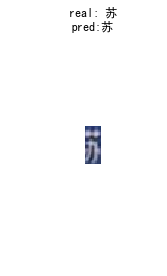

In [49]:
X, y = next(gen(1,captcha_list_img=captcha_list_img))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode([y_pred])))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

### 保存模型

In [50]:
#保存model 
from keras.models import model_from_json  
json_string = model.to_json()    
open('cnn.json','w').write(json_string)    
model.save_weights('cnn.h5')   

## 载入模型和载入参数

In [51]:
model2 = model_from_json(open('cnn.json').read())    
model2.load_weights('cnn.h5')  

#### 测试模型

(-0.5, 86.5, 147.5, -0.5)

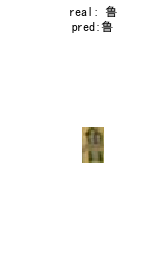

In [53]:
X, y = next(gen(1,captcha_list_img=captcha_list_img))
y_pred = model2.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode([y_pred])))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

#### 读入测试数据

In [54]:
try:
    captcha_dir_test=".\测试图像集\汉字"
    n_class_test,captcha_list_img_test,captcha_Dict_test=captcha_clean_img(captcha_dir=captcha_dir_test)
except Exception:
    captcha_dir_test="./测试图像集/汉字"
    n_class_test,captcha_list_img_test,captcha_Dict_test=captcha_clean_img(captcha_dir=captcha_dir_test)

云 的数量为： 15
京 的数量为： 34
冀 的数量为： 34
吉 的数量为： 13
宁 的数量为： 10
川 的数量为： 48
广 的数量为： 0
新 的数量为： 0
晋 的数量为： 19
桂 的数量为： 64
沪 的数量为： 29
津 的数量为： 12
浙 的数量为： 74
渝 的数量为： 40
湘 的数量为： 79
琼 的数量为： 14
甘 的数量为： 10
皖 的数量为： 68
粤 的数量为： 99
苏 的数量为： 70
蒙 的数量为： 11
藏 的数量为： 0
豫 的数量为： 66
贵 的数量为： 30
赣 的数量为： 68
辽 的数量为： 20
鄂 的数量为： 54
闽 的数量为： 52
陕 的数量为： 18
青 的数量为： 7
鲁 的数量为： 40
黑 的数量为： 16


### 检测预测数据集的图像大小是否超过模型最大值

In [55]:
width_test,height_test=getMaxHW(captcha_list_img_test)

a1_max: 73
a2_max: 38


## 计算模型总体准确率

In [56]:
evaluate(model,captcha_list_img=captcha_list_img_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.56it/s]


0.8671875

In [57]:
evaluate(model2,captcha_list_img=captcha_list_img_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.63it/s]


0.8828125